# COVID-19 Growth Analysis

* **Orignal_author:** Thomas Wiecki [URL](https://www.quantopian.com/posts/covid-19-growth-analysis)
* **Adapted by:** Vukosi Marivate and Alta de Waal, University of Pretoria

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

import requests
import io

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
number_of_days_since = 10 # You can change this to change the ouputs later
time_limit_since = [0,21] # days to up to after hitting number_of_days_since

In [4]:
def load_timeseries(name, 
                    base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'):
    url = f'{base_url}/time_series_covid19_{name}_global.csv'
    print ("URL: ", url)
    csv = requests.get(url).text
    df = pd.read_csv(io.StringIO(csv), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'
    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df, 
                    (df.loc[~df.state.isna()]
                     .groupby(['country', 'date', 'type'])
                     .sum()
                     .rename(index=lambda x: x+' (total)', level=0)
                     .reset_index(level=['country', 'type']))
                   ])
    return df

In [5]:
df_confirmed = load_timeseries('confirmed')

URL:  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv


/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [6]:
df_confirmed.head()

,cases,country,state,type
date,,,,
2020-01-22,0,Afghanistan,NaN,confirmed
2020-01-23,0,Afghanistan,NaN,confirmed
2020-01-24,0,Afghanistan,NaN,confirmed
2020-01-25,0,Afghanistan,NaN,confirmed
2020-01-26,0,Afghanistan,NaN,confirmed


In [7]:
df_confirmed.tail()

,cases,country,state,type
date,,,,
2020-03-29,258,United Kingdom (total),NaN,confirmed
2020-03-30,312,United Kingdom (total),NaN,confirmed
2020-03-31,331,United Kingdom (total),NaN,confirmed
2020-04-01,391,United Kingdom (total),NaN,confirmed
2020-04-02,455,United Kingdom (total),NaN,confirmed


In [8]:
df_confirmed.describe()

,cases
count,19080.000000
mean,892.152044
std,7353.524058
min,0.000000
25%,0.000000
50%,0.000000
75%,44.000000
max,243453.000000


In [9]:
# Estimated critical cases
p_crit = .05
df_confirmed = df_confirmed.assign(cases_crit=df_confirmed.cases*p_crit)

# Compute days relative to when 100 confirmed cases was crossed
df_confirmed.loc[:, 'days_since_' + str(number_of_days_since)] = np.nan
for country in df_confirmed.country.unique():
    df_confirmed.loc[(df_confirmed.country == country), 'days_since_'+ str(number_of_days_since)] = \
        np.arange(-len(df_confirmed.loc[(df_confirmed.country == country) & (df_confirmed.cases < number_of_days_since)]), 
                  len(df_confirmed.loc[(df_confirmed.country == country) & (df_confirmed.cases >= number_of_days_since)]))

In [10]:
## Plot Tooling
annotate_kwargs = dict(
    s='Based on COVID Data Repository by Johns Hopkins CSSE ({})\nAdapted by Vukosi Marivate and Alta de Waal, Original notebook by Thomas Wiecki'.format(df_confirmed.index.max().strftime('%B %d, %Y')), 
    xy=(0.05, 0.01), xycoords='figure fraction', fontsize=12)
figsize(16,9)

In [11]:
## Country names seem to change quite a bit
df_confirmed.country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Hong Kong',
       'Colombia', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Diamond Princess',
       'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana',
       'Haiti', 'Holy See', 'Honduras', 'Hungary', 'Ice

In [12]:
european_countries = ['Italy','Spain']
large_engl_countries = ['US',]
asian_countries = ['Singapore','Korea, South']
south_american_countries = []

african_countries = ['Egypt' ]
south_africa = ['South Africa']

country_groups = [european_countries, asian_countries, large_engl_countries, south_africa, african_countries]
line_styles = ['-', ':', '--', '-.', '-']

In [13]:
def plot_countries(df, countries, min_cases=50, ls='-', col='cases'):
    for country in countries:
        df_country = df.loc[(df.country == country) & (df.cases >= min_cases)]
        if len(df_country) == 0:
            continue
        df_country.reset_index()[col].plot(label=country, ls=ls)

(0, 21)

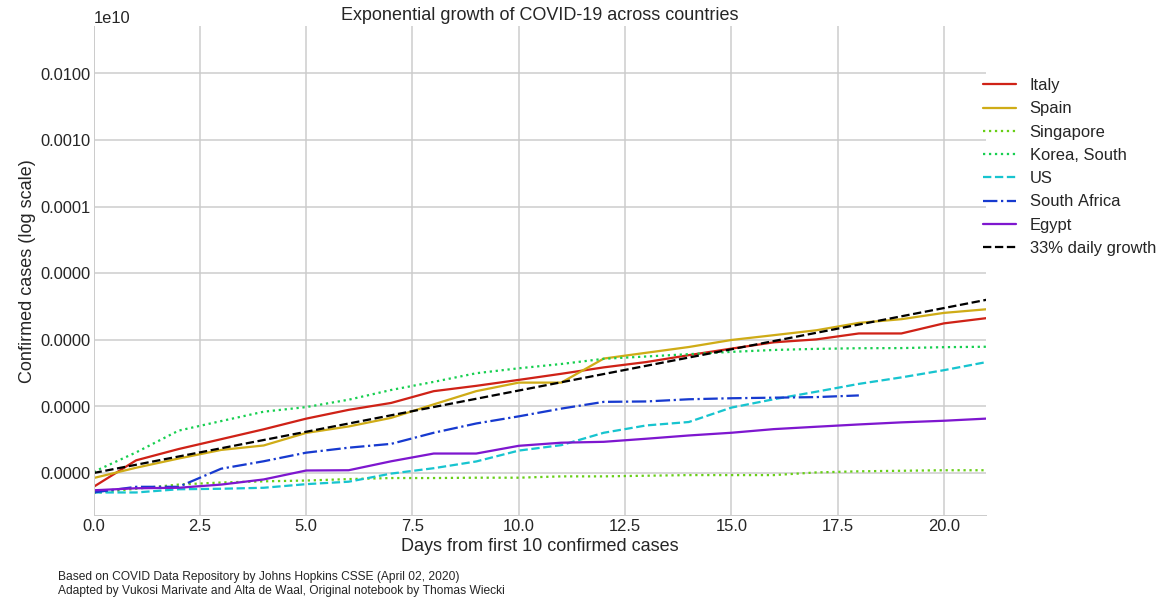

In [14]:
sns.set_palette(sns.hls_palette(8, l=.45, s=.8)) # 8 countries max
fig, ax = plt.subplots()

for countries, ls in zip(country_groups, line_styles):
    plot_countries(df_confirmed, countries, ls=ls)

x = np.linspace(0, plt.xlim()[1] - 1)
ax.plot(x, 100 * (1.33) ** x, ls='--', color='k', label='33% daily growth')

ax.set(yscale='log',
       title='Exponential growth of COVID-19 across countries',
       xlabel='Days from first '+str(number_of_days_since)+' confirmed cases',
       ylabel='Confirmed cases (log scale)')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend(bbox_to_anchor=(.98, .5))
ax.annotate(**annotate_kwargs)
sns.despine();
plt.xlim(time_limit_since)

In [15]:
## Do you want to save this
# fig.savefig('../visualisation//covid-growth-countries.png', 
#                bbox_inches='tight', 
#                transparent=True,
#                pad_inches=0, dpi = 200)

(0, 21)

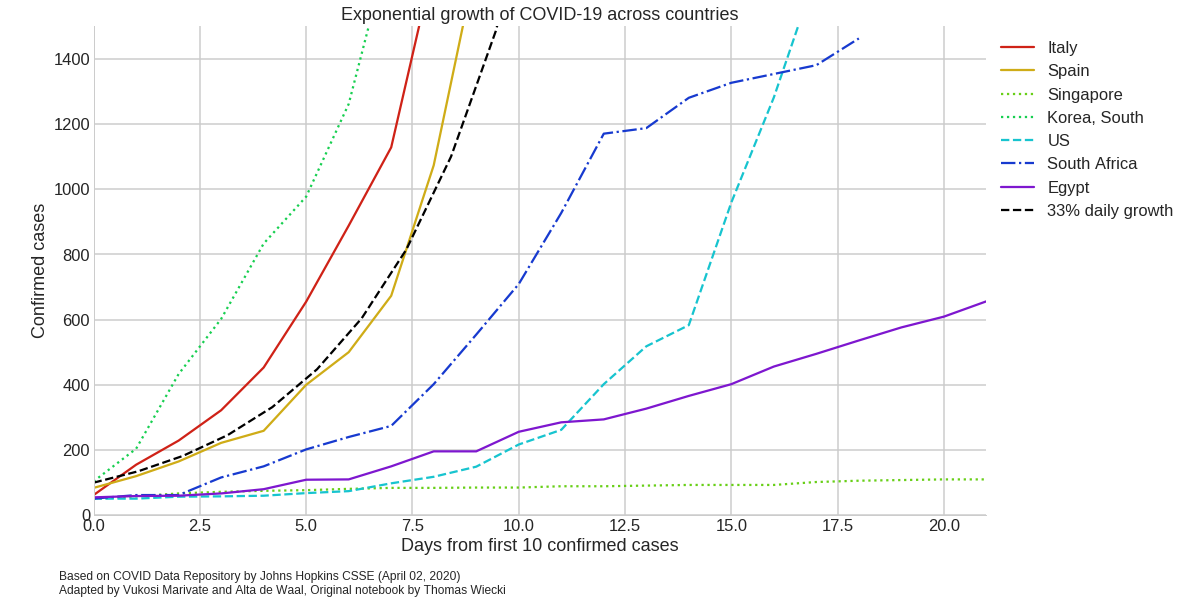

In [16]:
#collapse-hide
fig, ax = plt.subplots()

for countries, ls in zip(country_groups, line_styles):
    plot_countries(df_confirmed, countries, ls=ls)

x = np.linspace(0, plt.xlim()[1] - 1)
ax.plot(x, 100 * (1.33) ** x, ls='--', color='k', label='33% daily growth')

ax.set(title='Exponential growth of COVID-19 across countries',
       xlabel='Days from first '+str(number_of_days_since)+' confirmed cases',
       ylabel='Confirmed cases', ylim=(0, 30000))
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.annotate(**annotate_kwargs)
sns.despine();
# plt.xlim([0,1000])
plt.ylim([0,1500])
plt.xlim(time_limit_since)

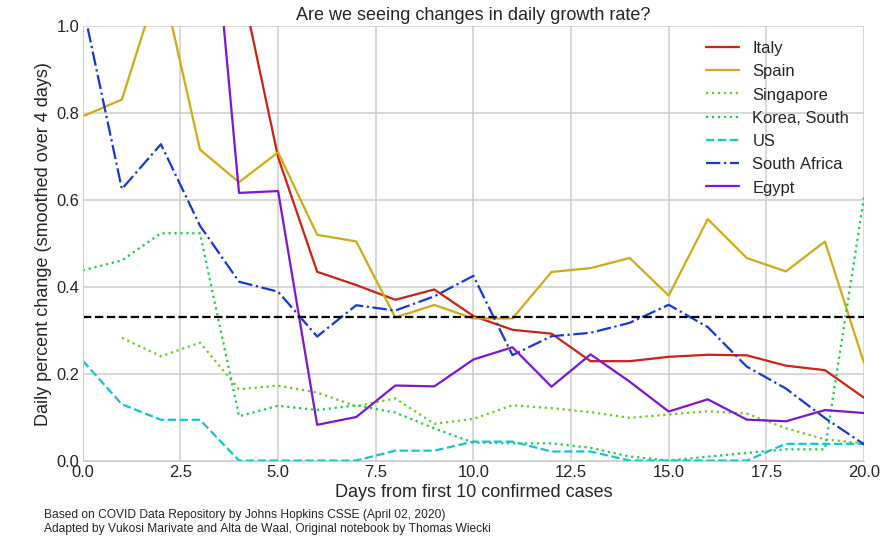

In [17]:
#collapse-hide
smooth_days = 4
fig, ax = plt.subplots(figsize=(14, 8))
df_confirmed['pct_change'] = (df_confirmed
                              .groupby('country')
                              .cases
                              .pct_change()
                              .rolling(smooth_days)
                              .mean()
)

for countries, ls in zip(country_groups, line_styles):
    (df_confirmed.set_index('country')
                 .loc[countries]
                 .loc[lambda x: x.cases > number_of_days_since]
                 .reset_index()
                 .set_index('days_since_'+str(number_of_days_since))
                 .groupby('country', sort=False)['pct_change']
                 .plot(ls=ls)
    )

ax.set(ylim=(0, 1),
       xlim=(0, 20),
       title='Are we seeing changes in daily growth rate?',
       xlabel='Days from first '+str(number_of_days_since)+' confirmed cases',
       ylabel='Daily percent change (smoothed over {} days)'.format(smooth_days),
)
ax.axhline(.33, ls='--', color='k')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(bbox_to_anchor=(1.0, 1.0))
sns.despine()
ax.annotate(**annotate_kwargs);

Updated daily by [GitHub Actions](https://github.com/features/actions).

This visualization was made and adapted by Vukosi Marivate and Alta De Waal. Original visualisation by [Thomas Wiecki](https://twitter.com/twiecki)[1].

[1]:  Data sourced from ["2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE"](https://systems.jhu.edu/research/public-health/ncov/) [GitHub repository](https://github.com/CSSEGISandData/COVID-19) and recreates the (pay-walled) plot in the [Financial Times]( https://www.ft.com/content/a26fbf7e-48f8-11ea-aeb3-955839e06441). This code is provided under the [BSD-3 License](https://github.com/twiecki/covid19/blob/master/LICENSE). Link to [original notebook](https://github.com/twiecki/covid19/blob/master/covid19_growth.ipynb).